In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt

In [5]:
# Sample of apartment prices of 2020 from Ciudad Autonoma de Buenos Aires
apt_prices_caba = pd.read_csv('../../data/departamentos-en-venta-2020.csv')

loans_income = pd.read_csv('../../data/loans_income.csv')

## Sampling Distribution of a Statistic

- The frequency distribution of a **sample statistic** tells us how that metric would turn out differently from sample to sample.
- This sampling distribution can be estimated via the **bootstrap**, or via formulas that rely on the central limit theorem.
- A key metric that sums up the variability of a sample statistic is its **standard error**.

In [6]:
sample_data = pd.DataFrame({ # Sample of 2000 apartment prices
    'price': apt_prices_caba['Dolares'].sample(2000),
    'type': 'Data'
})
sample_mean_5 = pd.DataFrame({ # Sample of 2000 means of 5 prices
    'price': [apt_prices_caba['Dolares'].sample(5).mean() for _ in range(2000)],
    'type': 'Mean of 5'
})
sample_mean_20 = pd.DataFrame({ # Sample of 2000 means of 20 prices
    'price': [apt_prices_caba['Dolares'].sample(20).mean() for _ in range(2000)],
    'type': 'Mean of 20'
})
sample_mean_50 = pd.DataFrame({ # Sample of 2000 means of 50 prices
    'price': [apt_prices_caba['Dolares'].sample(50).mean() for _ in range(2000)],
    'type': 'Mean of 50'
})

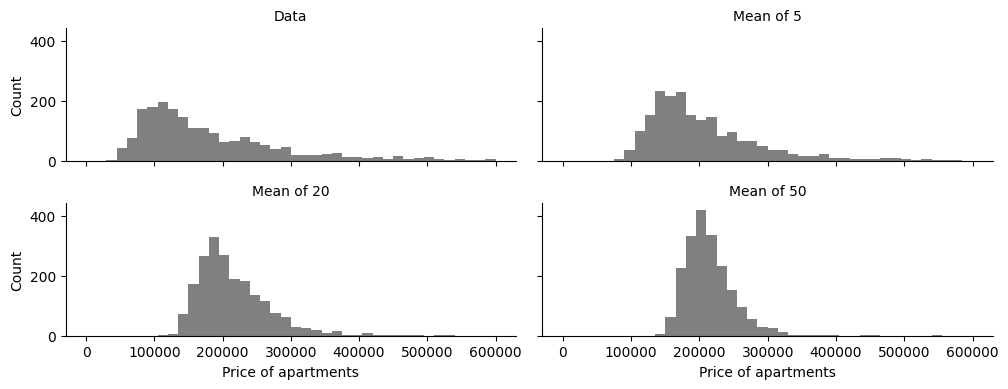

In [7]:
results = pd.concat([sample_data, sample_mean_5, sample_mean_20, sample_mean_50])
g = sns.FacetGrid(results, col='type', col_wrap=2, height=2, aspect=2.5)
g.map(plt.hist, 'price', range=[0, 6e5], bins=40, color='grey')
g.set_axis_labels('Price of apartments', 'Count')
g.set_titles('{col_name}')

The histogram of the individual data values is broadly spread out and skewed toward higher prices (outliers), as is to be expected with income data. The histograms of the means of 5, 20 and 50 are increasingly compact and more normal-shaped.  

### Why?
The distribution of a **sample statistic such as the mean** is likely to be more **regular and bell-shaped** than the distribution of the data itself. The larger the sample the statistic is based on, the more this is true. Also, the larger the sample, the narrower the distribution of the sample statistic.  

The science behind it is the **Central Limit Theorem**: the means drawn from multiple samples will resemble the familiar bell-shaped normal curve — even if the source population is not normally distributed.

In [8]:
# Compute standars deviations
sample_data_std = sample_data['price'].std()
sample_mean_5_std = sample_mean_5['price'].std()
sample_mean_20_std = sample_mean_20['price'].std()
sample_mean_50_std = sample_mean_50['price'].std()

# Compute standard errors
se_data = sample_data_std / np.sqrt(2000)
se_mean_5 = sample_mean_5_std / np.sqrt(2000)
se_mean_20 = sample_mean_20_std / np.sqrt(2000)
se_mean_50 = sample_mean_50_std / np.sqrt(2000)

print("Standard Errors:")
print("Sample Data:", se_data)
print("Sample Mean of 5:", se_mean_5)
print("Sample Mean of 20:", se_mean_20)
print("Sample Mean of 50:", se_mean_50)

Standard Errors:
Sample Data: 5805.604841787493
Sample Mean of 5: 2418.1278261852176
Sample Mean of 20: 1223.2798999047156
Sample Mean of 50: 799.2650097341997


Text(0.5, 1.0, 'Central Limit Theorem')

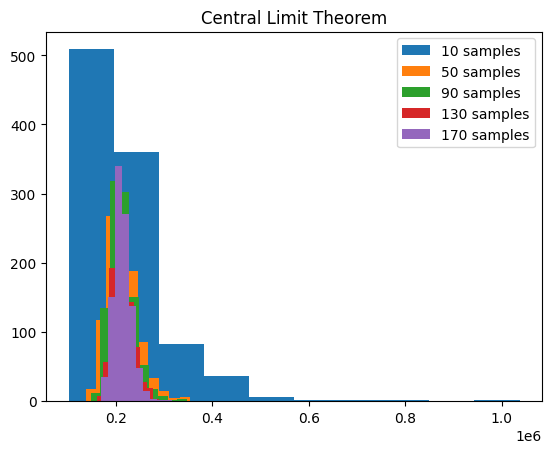

In [9]:
sample_amounts = range(10, 200, 40)

# Take 1000 thousands of each sample_amount

for q in sample_amounts:
    samples = []
    for i in range(1000):
        new_sample = (apt_prices_caba['Dolares']).sample(n=q).mean()
        samples.append(new_sample)
    plt.hist(samples)
plt.legend([str(q) + " samples" for q in sample_amounts])
plt.title('Central Limit Theorem')
    

## Bootstrapping

- The bootstrap (sampling with replacement from a data set) is a powerful tool for assessing the variability of a sample statistic.
- The bootstrap can be applied in similar fashion in a wide variety of circumstances, without extensive study of mathematical approximations to sampling distributions.
- It also allows us to estimate sampling distributions for statistics where no mathematical approximation has been developed, nor no mathematical information about the population is given.
- When applied to predictive models, aggregating multiple bootstrap sample predictions (bagging) outperforms the use of a single model.


In [10]:
# Take the sample of the apartments, specifically the m^2 prices
apt_m2_prices = apt_prices_caba['DolaresM2']

bootstrap_results = []
for _ in range(1000):
    new_sample = resample(apt_m2_prices)
    bootstrap_results.append(new_sample.median())

bootstrap_results = pd.Series(bootstrap_results)
print('Bootstrap Statistics:')
print(f'Original median: {apt_m2_prices.median()}')
print(f'Bias: {round(bootstrap_results.mean() - apt_m2_prices.median(), 4)}')
print(f'Std. error: {round(bootstrap_results.std(), 4)}')

Bootstrap Statistics:
Original median: 2757.0
Bias: -0.3225
Std. error: 3.0243


The bootstrap does not compensate for a small sample size; it does not create new data, nor does it fill in holes in an existing data set. It merely informs us about how lots of additional samples would behave when drawn from a population like our original sample.

## Confidence Intervals

- Confidence intervals are the typical way to present estimates as an interval range.
- The more data you have, the less variable a sample estimate will be.
- The lower the level of confidence you can tolerate, the narrower the confidence interval will be.
- The bootstrap is an effective way to construct confidence intervals.

Text(2753, 200, '90% Confidence Interval\n[2750, 2761]')

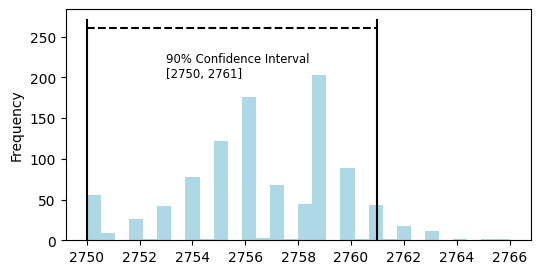

In [11]:
confidence_interval = list(bootstrap_results.quantile([0.05, 0.95]))
ax = bootstrap_results.plot.hist(bins=30, figsize=(6, 3), color='lightblue')

ax.plot(confidence_interval, [260, 260], color='black', linestyle='--')
for x in confidence_interval:
    ax.plot([x, x], [0, 270], color='black')

mean_value = bootstrap_results.mean()
ax.text(2753, 200, 
        f'90% Confidence Interval\n[{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}]',
       fontsize='small')

## Normal Distribution and QQ-plot

- The normal distribution was essential to the historical development of statistics, as it permitted mathematical approximation of uncertainty and variability.
- While raw data is typically not normally distributed, errors often are, as are averages and totals in large samples.
- To convert data to z-scores, you subtract the mean of the data and divide by the standard deviation; you can then compare the data to a normal distribution.
- A QQ-Plot is used to visually determine how close a sample is to a specified distribution — in this case, the normal distribution.

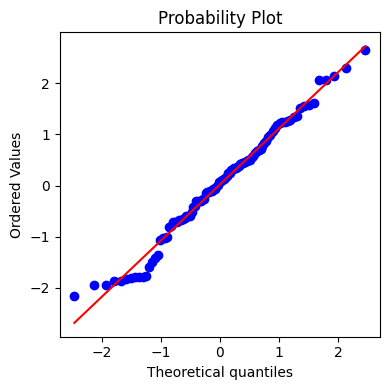

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
# generate random sample that follows a normal distrib of 100 values
norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax)

plt.tight_layout()

### Some other distributions

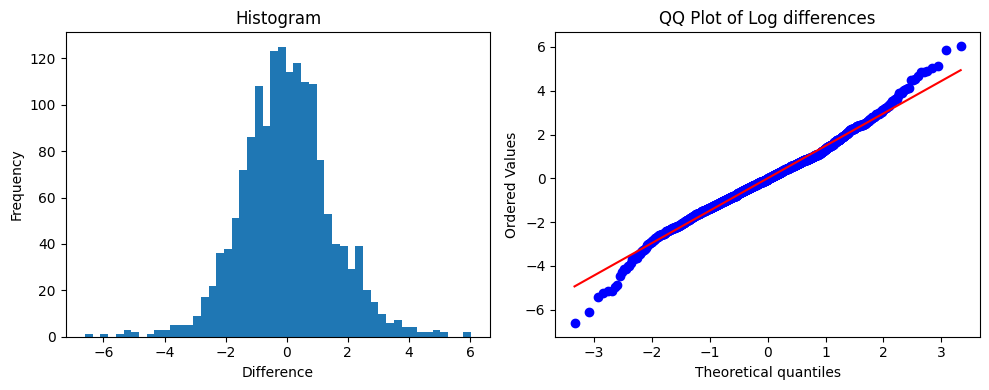

In [35]:
sp500_px = pd.read_csv('../../data/sp500_data.csv')

## Long-Tailed Distributions

nflx = sp500_px['NFLX']

# keep positive values and calculate the difference between 
# consecutive elements in the log-transformed series
nflx = nflx[nflx>0] 
log_diff_nflx = np.diff(np.log(nflx))
# Taking the logarithm of stock prices is a common step in financial analysis
# to stabilize the variance and convert multiplicative relationships into additive ones

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes[0].hist(x=log_diff_nflx, bins=50)
axes[0].set_title('Histogram')
axes[0].set_xlabel('Difference')
axes[0].set_ylabel('Frequency')

# Plot probability plot
stats.probplot(log_diff_nflx, plot=axes[1])
axes[1].set_title('QQ Plot of Log differences')

plt.tight_layout()

In [16]:
## Binomial Distribution

print(stats.binom.pmf(2, n=5, p=0.1))

print(stats.binom.cdf(2, n=5, p=0.1))

0.07289999999999992
0.99144


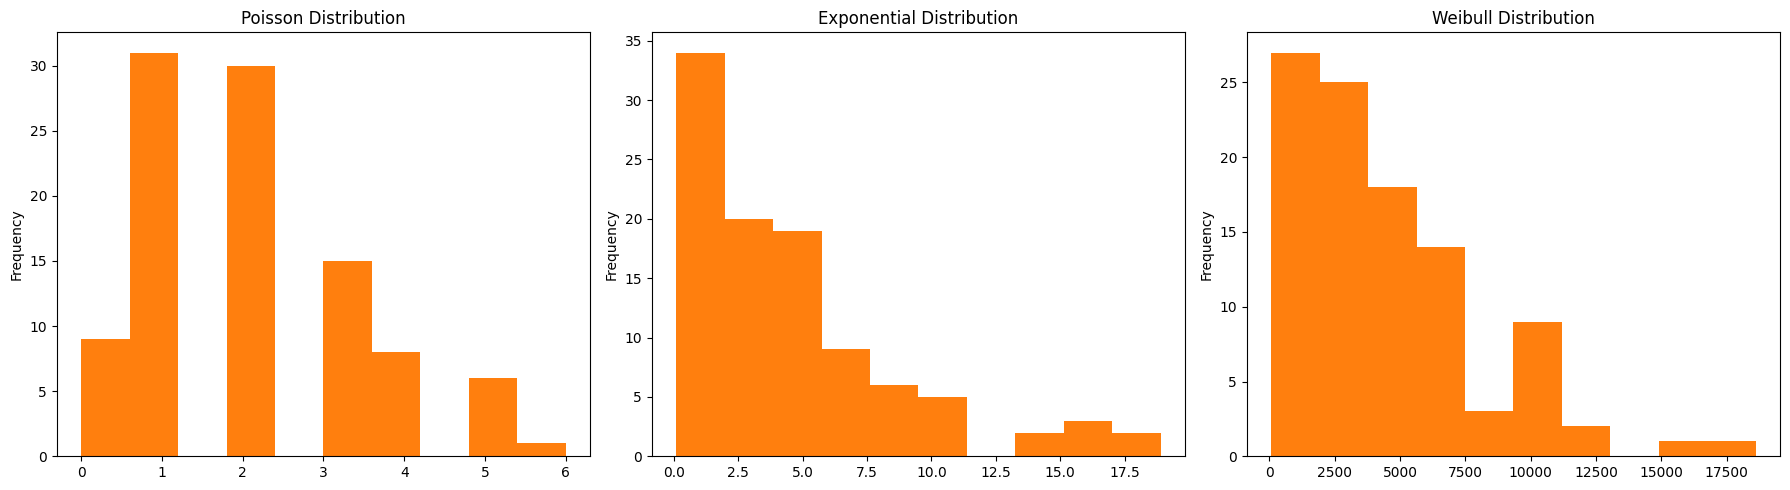

In [17]:
# Generate samples
poisson_sample = stats.poisson.rvs(2, size=100)
expon_sample = stats.expon.rvs(scale=5, size=100)
weibull_sample = stats.weibull_min.rvs(1.5, scale=5000, size=100)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot Poisson distribution
pd.Series(poisson_sample).plot.hist(ax=axes[0], title='Poisson Distribution', color='C1')

# Plot Exponential distribution
pd.Series(expon_sample).plot.hist(ax=axes[1], title='Exponential Distribution', color='C1')

# Plot Weibull distribution
pd.Series(weibull_sample).plot.hist(ax=axes[2], title='Weibull Distribution', color='C1')

# Display the figure
plt.tight_layout()
plt.show()

## Summary

In the era of big data, the principles of random sampling remain crucial for obtaining accurate estimates. Random selection of data helps reduce bias and ensures a higher quality dataset compared to using conveniently available data. Understanding various sampling and data-generating distributions is essential, as it enables us to quantify potential errors in estimates caused by random variation. Additionally, the bootstrap method—sampling with replacement from an observed dataset—offers a versatile and effective way to assess potential errors in sample estimates. This "one size fits all" approach is particularly valuable in diverse and complex data environments.